# Setup

In [1]:
include(joinpath("..","src","setup.jl"))
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/davidlittle/.julia/packages/Compose/BYWXX/src/Compose.jl:161
┌ Warning: Package Compose does not have Cairo in its dependencies:
│ - If you have Compose checked out for development and have
│   added Cairo as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Compose
│ Loading Cairo into Compose from project dependency, future warnings for Compose are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/ew1SM/src/mapping.jl:228


"../data/count_lengths/run_2018-11-26"

# TODO: 

- work out the parameters to vary
- run a simulation

## New plans

Once that's done I can work on the New Stimuli notebook and check out context. At that point I can see if the same problem with 12st persists, and really get in to the context stimuli.

In [4]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")
settings = TOML.parsefile(settings)

Dict{AbstractString,Any} with 9 entries:
  "percept_lengths" => Dict{AbstractString,Any}("threshold"=>0.2,"min_length_ms…
  "freqs"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "mask"            => Dict{AbstractString,Any}("window_ms"=>500,"delta_ms"=>25…
  "rates"           => Dict{AbstractString,Any}("rates_Hz"=>[2, 4, 8, 16, 32],"…
  "scales"          => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "stimulus"        => Dict{AbstractString,Any}("repeats"=>100,"ramp_len_ms"=>1…
  "track"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "nmf"             => Dict{AbstractString,Any}("skipframes"=>0,"tol"=>0.001,"w…
  "bandwidth_ratio" => Dict{AbstractString,Any}("window_ms"=>800,"full_band_rat…

In [5]:
results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-26T17:38:30.128,1
2,23.3,1,2018-11-26T17:40:27.495,1
3,23.3,1,2018-11-26T17:40:30.437,1
4,23.3,1,2018-11-26T17:40:33.359,1
5,23.3,1,2018-11-26T17:40:36.249,1
6,23.3,1,2018-11-26T17:40:39.153,1


# Object-level build-up

In [6]:
settings["track"]["analyze"]["source_prior_sd_bias"] = [0,1000,0]
settings["track"]["analyze"]["source_prior_strength_bias"] = [0,2000]
settings["stimulus"]["repeats"] = 30
settings["min_length_ms"] = 250

250

In [20]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 3.0
p.s_c_σ = 1.0
run1 = bistable_model(p,settings,intermediate_results=true);

┌ Info: 0.69% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/eT3qD/src/nmf.jl:45


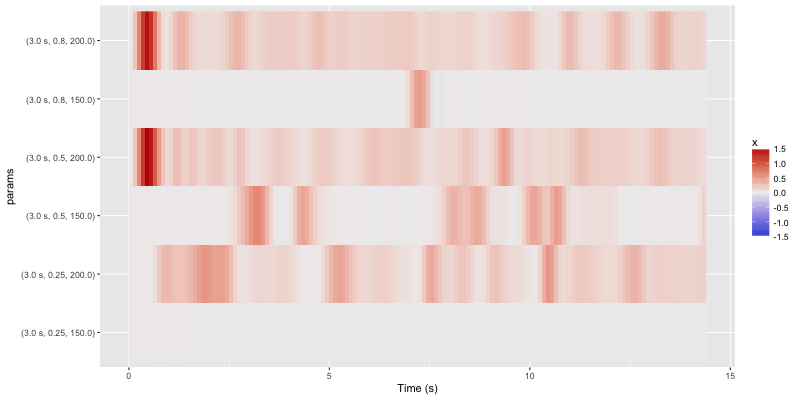

RObject{VecSxp}


In [21]:
rplot(run1.sources.outweights)

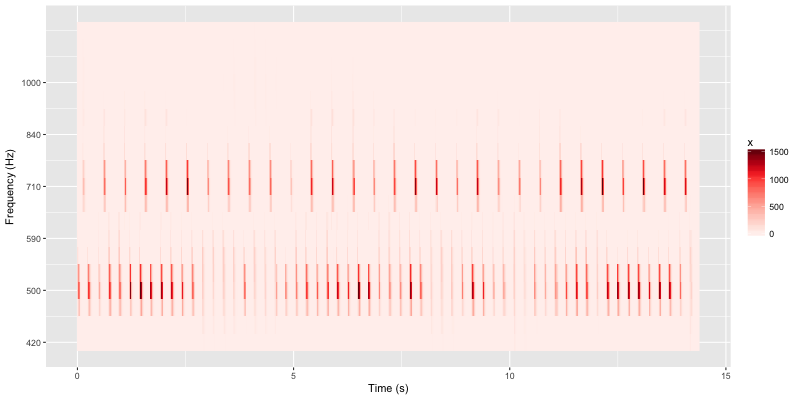

RObject{VecSxp}


In [22]:
rplot(run1.primary_source)

In [29]:
using Logging

In [30]:
result = []
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.0
p.s_c_σ = 0.3
@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup = vcat(result...)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:12


,length,response,run
,Float64,Int64,Int64
1,0.4,2,1
2,4.0,1,1
3,2.2,2,1
4,5.0,1,1
5,0.8,2,1
6,1.3,1,1
7,0.4,2,2
8,4.5,1,2
9,0.3,2,2


In [25]:
head(buildup)

,length,response,run
,Float64,Int64,Int64
1,2.3,2,1
2,0.8,1,1
3,1.6,2,1
4,9.0,1,1
5,0.4,2,2
6,0.6,1,2


In [26]:
sdf = buildup_mean(buildup,delta=0.24,length=14);

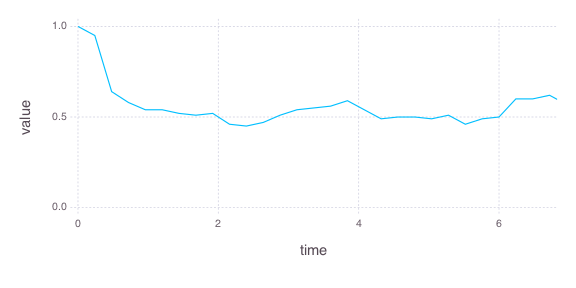

false

In [27]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=6.72)))

In [15]:
hdf = CSV.read(joinpath("..","analysis","context","exp1A.csv"))
head(hdf)

,Column1,sid,sample,time,context_A,context_B,st,test_A,test_B,response,same_freq
,Int64⍰,String⍰,Int64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰
1,1,CK,1,0.24,1,1,0,300,424,0,FALSE
2,2,CK,2,0.48,1,1,0,300,424,0,FALSE
3,3,CK,3,0.72,1,1,0,300,424,0,FALSE
4,4,CK,4,0.96,1,1,0,300,424,0,FALSE
5,5,CK,5,1.2,1,1,0,300,424,0,FALSE
6,6,CK,6,1.44,1,1,0,300,424,0,FALSE


In [16]:
delta = diff(hdf.time[1:2])[1]

0.24

In [17]:
hdf_mean = @linq hdf |>
  where((:st .== 6) .& (:same_freq.=="TRUE")) |>
  by(:time,response = mean(:response))
head(hdf_mean)

,time,response
,Float64⍰,Float64
1,0.24,0.0
2,0.48,0.0
3,0.72,0.0
4,0.96,0.0
5,1.2,0.00925926
6,1.44,0.037037


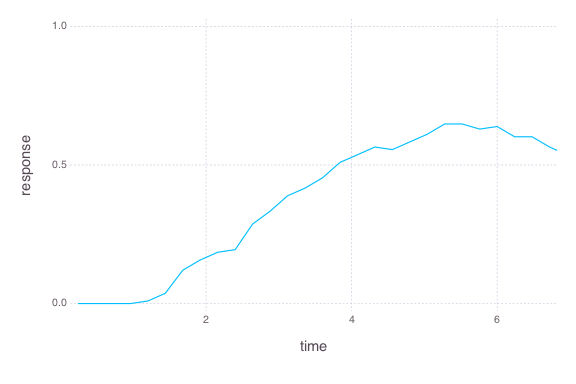

false

In [18]:
draw(PNG(6inch,4inch),plot(hdf_mean,x=:time,y=:response,Geom.line,Coord.cartesian(xmax=6.72,ymax=1.0)))

In [19]:
rms(sdf.value[0.0 .< sdf.time .< 6.72] .- hdf_mean.response[hdf_mean.time .< 6.72])

0.22114674596182657